In [1]:
import numpy as np
import numpy.ma as ma
from numpy import diff
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

import xarray as xr

In [2]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_pulse10'
gridT = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_T.nc')
gridU = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_U.nc')
gridV = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_V.nc')
gridW = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_W.nc')
#sal = np.tile(gridT['vosaline'][:,:20,:,:],(1,1))
#tem = np.tile(gridT['votemper'][:,:20,:,:],(1,1))
#utau = np.tile(gridU['sozotaux'],(1,1))
#vtau = np.tile(gridV['sometauy'],(1,1))
#vE = gridW['veddyvisc'][:,:20,:,:]
#depthw = gridW['depthw'][:20]
#deptht = gridT['deptht'][:20]
#nav_lat = gridT['nav_lat']
#nav_lon = gridT['nav_lon']

sal = np.tile(gridT['vosaline'][:,:20,:,:],(1,1))
tem = np.tile(gridT['votemper'][:,:20,:,:],(1,1))
utau = np.tile(gridU['sozotaux'],(1,1))
vtau = np.tile(gridV['sometauy'],(1,1))
vE = gridW['veddyvisc'][:,:20,:,:]
depthw = gridW['depthw'][:20]
deptht = gridT['deptht'][:20]
nav_lat = gridT['nav_lat']
nav_lon = gridT['nav_lon']

/home/imachuca/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:377: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


In [3]:
grid_g = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/raw_coordinates/grid_02.nc')
lon_g_grid = grid_g['grid_lons'][:-3,:-3]
lat_g_grid = grid_g['grid_lats'][:-3,:-3]

In [4]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']
coord_nav_lat = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

# Eddy viscosity in domain at time and depth

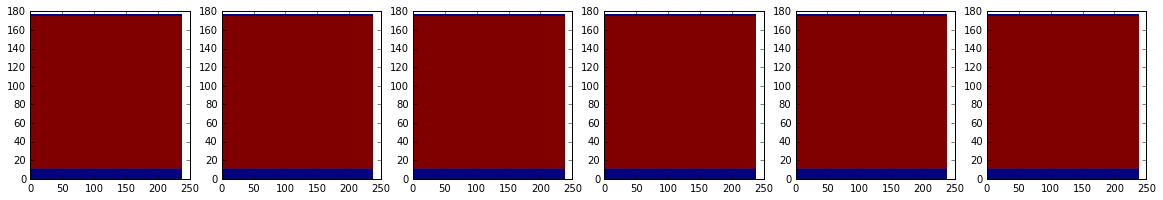

In [5]:
fig, ax = plt.subplots(1,6,figsize=(20,3), sharex=True)
for t, d, i in zip([200,203,206,200,203,206], [0,0,0,1,1,1], np.arange(6)):
    p = ax[i].pcolor(vE[t,d,:,:], vmin = 0, vmax=0.000105) #sensitivity studies for eddy viscosity (tke key)
    #low in arctic but higher in canyons

# Wind stress and eddy viscosity

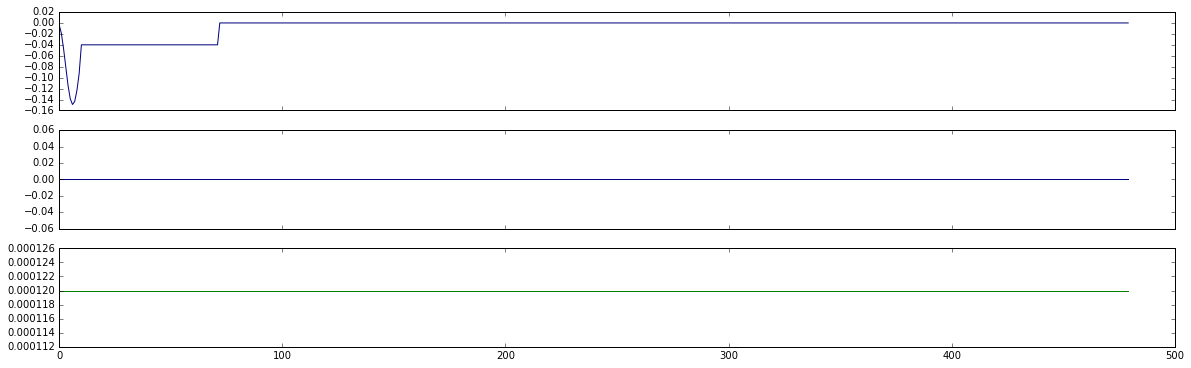

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,6), sharex=True)
ax1.plot(utau[:,100,100], c='navy')
ax2.plot(vtau[:,100,100], c='navy')
ax3.plot(vE[:,0,100,100], c='y')
ax3.plot(vE[:,2,100,100], c='r')
ax3.plot(vE[:,4,100,100], c='b')
ax3.plot(vE[:,7,100,100], c='g')

# Coriolis parameter

$$f(\lambda)= 2 \Omega \sin(\lambda)$$

$$\Omega = \frac{2 \pi}{24 hours}$$

The average latitude at the northern boundary is 70.943. The average coriolis parameter is 0.0001374. fpar was calculated at all points along the boundary.

In [7]:
indN = -2
latN = nav_lat[indN,:]
omega = (2 * np.pi) / (24 * 60 * 60)
f = 2 * omega * np.sin(np.deg2rad(latN))

In [8]:
f.shape, type(f), np.mean(f)

((237,), xarray.core.dataarray.DataArray, <xarray.DataArray 'nav_lat' ()>
 array(0.0001374559069518)
 Coordinates:
     y        int64 175)

# Ekman layer thickness

$$\delta = \sqrt \frac{2\nu_E}{f}$$

In [9]:
indt = 0
vEN = vE[indt, :, -2, :]
fN = np.tile(f,(vEN.shape[0],1))
delta = np.sqrt((2 * vEN) / fN)

In [10]:
vEN.shape, fN.shape, delta.shape

((20, 237), (20, 237), (20, 237))

# Ekman component

$$u_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) - \tau_y sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

$$v_E = \frac{\sqrt2}{\rho f \delta} e^{z/\delta} \Bigg[ \tau_x  sin \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) + \tau_y cos \Bigg( \frac{z}{\delta} - \frac{\pi}{4} \Bigg) \Bigg]$$

In [11]:
deps = np.transpose(np.tile(-1 * deptht, (237, 1)))
lats = np.tile(latN, (deps.shape[0], 1))
p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [deps,lats], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

deps.shape, lats.shape, type(deps), type(lats)

((20, 237), (20, 237), numpy.ndarray, numpy.ndarray)

In [12]:
SA = sal[indt, :, indN, :]
CT = tem[indt, :, indN, :]
rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

SA.shape, rho.shape, type(SA), type(rho)

((20, 237), (20, 237), numpy.ndarray, numpy.ndarray)

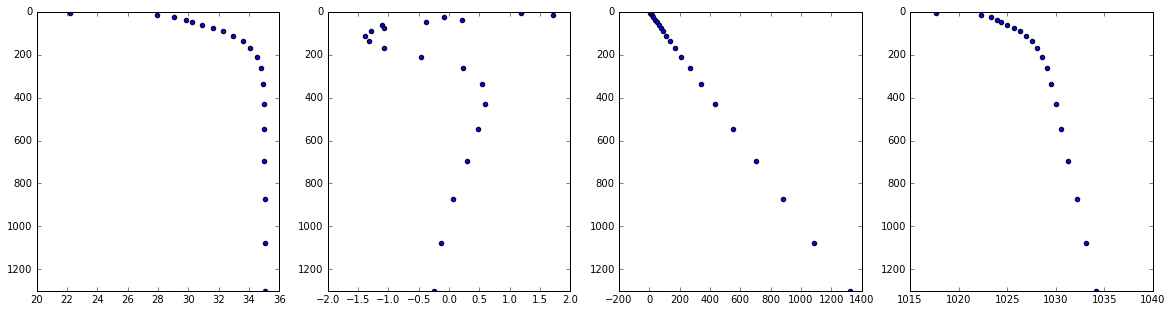

In [13]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
for var, i in zip([SA, CT, p, rho], np.arange(4)):
    ax[i].scatter(var[:,100], deptht)
    ax[i].set_ylim([1300, 0])

In [14]:
coeff = (np.sqrt(2)/(rho * fN * delta)) * np.exp(deps / delta)

brackets = (deps / delta) - (np.pi / 4)

tao_x = np.tile(utau[indt, indN, :],(brackets.shape[0],1))
tao_y = np.tile(vtau[indt, indN, :],(brackets.shape[0],1))

u_E = coeff * ((tao_x * np.cos(brackets)) - (tao_y * np.sin(brackets)))
v_E = coeff * ((tao_x * np.sin(brackets)) - (tao_y * np.cos(brackets)))

/home/imachuca/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:396: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [15]:
coeff.shape, brackets.shape, tao_x.shape, u_E.shape

((20, 237), (20, 237), (20, 237), (20, 237))

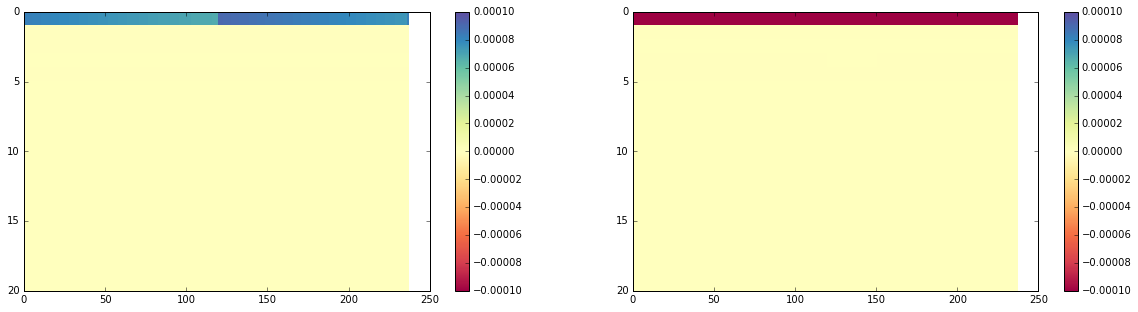

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
for ax, vel_E in zip([ax1, ax2], [u_E, v_E]):
    p = ax.pcolor(vel_E, vmin=-0.0001, vmax=0.0001, cmap=cm.Spectral)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()

# Pressure driven component

References:
* http://www.rsmas.miami.edu/users/lbeal/MPO603/Lecture%2012.xhtml
* https://ocw.mit.edu/courses/mechanical-engineering/2-011-introduction-to-ocean-science-and-engineering-spring-2006/readings/geostrophic.pdf
* https://marine.rutgers.edu/dmcs/ms501/2004/Notes/Wilkin20041101.htm
* http://talleylab.ucsd.edu/ltalley/sio210/dynamics_rotation/lecture_dynamics_geostrophy.pdf
* http://onlinelibrary.wiley.com/doi/10.1002/2015JC011579/full

Ekman transport resulting from winds distorts the sea surface height. These distortions (hills and valleys) produce geostrophic currents which dominate the large scale circulation patterns in the upper ocean (Beaufort Gyre). Increased pressure caused by the piling up of surface water causes water to flow away.



$$ v_g = \frac{1}{\rho f} \frac{\partial p}{\partial x} $$

$$ u_g = - \frac{1}{\rho f} \frac{\partial p}{\partial y} $$

And:
$$ p = \int_{-z}^{\eta} g \rho(z) dz = \int_{0}^{\eta} g \rho(z) dz + \int_{-z}^{0} g \rho(z) dz$$

So the geostrophic currents are:
$$u_g = - \frac{1}{\rho f}\frac{\partial}{\partial y} \int_{-z}^{0} g \rho(z) dz - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

$$v_g = \underbrace{\frac{1}{\rho f}\frac{\partial}{\partial x} \int_{-z}^{0} g \rho(z) dz}_\text{V baroclinic} + \underbrace{\frac{g}{f} \frac{\partial \eta}{\partial x}}_\text{V barotropic}$$


# Barotropic rossby radii
$a_s$: barotropic rossby radius over the shelf

$h_S$: depth for y<S

$$a_s = \frac{\sqrt{gh_s}}{f}$$

$a_d$: barotropic rossby radius off the shelf

$h_d$: depth for y>S

$$a_d = \frac{\sqrt{gh_d}}{f}$$

And:
$$\alpha^2 = \frac{H_S}{H_D}$$

In [17]:
h_s = 80; h_d = 1300
a_s = np.sqrt(9.81 * h_s) / np.mean(f)
a_d = np.sqrt(9.81 * h_d) / np.mean(f)
alpha = np.sqrt(h_s / h_d)

print(int(a_s), int(a_d), alpha)

203805 821566 0.248069469178


# Allen 1996

$$\eta = - \frac{\int_{t_0}^{t_f} \tau dt}{f^2 a_s} \bigg( \frac{1}{\alpha \sinh (S/a_s) + \cosh(S/a_s)} \bigg) \exp \bigg[\frac{-(y-S)}{a_d} \bigg]$$

* y=0 at the coast and increases offshore
* S: distance to the shelf break

In [18]:
tau_integral = np.trapz(utau[:,0,0])
coeff_eta = (-1 * tau_integral) / ((np.mean(f))**2 * a_s)

tau_integral, utau.max(), utau.min()

(-3.3878807682776824, 0.0, -0.14908270537853241)

In [19]:
#lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')
#x_wall, y_wall = functions_idealized.extended_measurements(lon_s_grid, lat_s_grid)

x_wall = bathy_file['X'][0,:][-1]
y_wall = bathy_file['Y'][:,0][-1]

x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(x_wall, y_wall)

x_wall, y_wall, y_wall - y_break

(546064.86328401405, 405234.2962823509, 146259.7140481)

In [20]:
S_y = y_wall - y_break
arg = S_y / a_s
brackets_eta = 1 / ((alpha * np.sinh(arg)) + np.cosh(arg))

In [21]:
y_all = bathy_file['Y'][:,0]
exp_eta = np.exp((-1 * (y_all - S_y)) / a_d.values)

In [22]:
eta = coeff_eta.values * brackets_eta.values * exp_eta

In [23]:
coeff_eta.shape, brackets_eta.shape, y_all.shape, exp_eta.shape, eta.shape

((), (), (177,), (177,), (177,))

# Geostrophic currents

$$u_g = - \frac{g}{f} \frac{\partial \eta}{\partial y}$$

$$v_g = +\frac{g}{f} \frac{\partial \eta}{\partial x} = 0$$

In [24]:
u_g = -1 * (9.81 / np.mean(f)).values * (diff(eta) / diff(y_all))
u_g_bc = np.zeros_like(u_E)
u_g_bc[0,:] = u_g[-1]

v_g_bc = np.zeros_like(v_E)
print(u_g.shape, u_g[-1], u_g.max(), u_g.min())

(176,) 38.1833854151 62.2684217176 38.1833854151


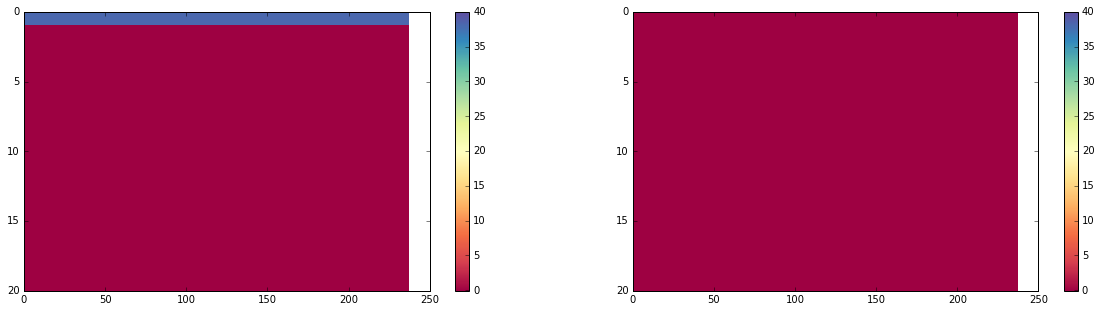

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
for ax, vel_g in zip([ax1, ax2], [u_g_bc, v_g_bc]):
    p = ax.pcolor(vel_g, vmin=-0.1, vmax=40, cmap=cm.Spectral)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()

# Total velocities

$$u = u_g + u_E$$
$$v = v_g + v_E$$

In [25]:
u_g.shape, u_g_bc.shape, u_E.shape, v_g_bc.shape, v_E.shape

((176,), (20, 237), (20, 237), (20, 237), (20, 237))

In [26]:
u_tot = u_g_bc + u_E
v_tot = v_g_bc + v_E

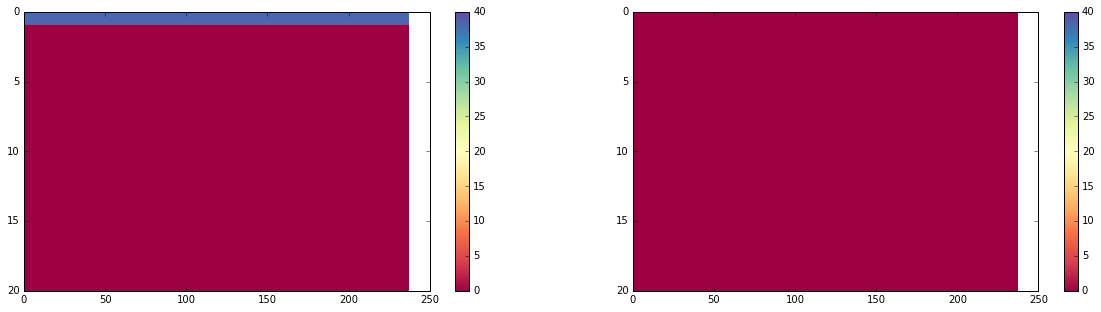

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
for ax, vel_tot in zip([ax1, ax2], [u_tot, v_tot]):
    p = ax.pcolor(vel_tot, vmin=-0.0005, vmax=40, cmap=cm.Spectral)
    fig.colorbar(p, ax = ax)
    ax.invert_yaxis()